In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.animation as animation
import datetime
import seaborn as sns
import missingno as msno
import firebase_admin
from firebase_admin import credentials, db
from datetime import datetime  # Untuk konversi timestamp ke human-readable
sns.set_theme(style="whitegrid")
%matplotlib inline 

In [2]:
# Konfigurasi database sumber
source_cred = credentials.Certificate("D:/staklimjerukagung-firebase-adminsdk-kcfma-e091165a9b.json")
firebase_admin.initialize_app(source_cred, {
    'databaseURL': 'https://staklimjerukagung-default-rtdb.asia-southeast1.firebasedatabase.app/'
})

In [3]:
# Input readable date
start_readable_date = "01-08-2025 00:00:00"  # Format: DD-MM-YYYY HH:MM:SS
end_readable_date = "30-08-2025 23:59:59"  # Format: DD-MM-YYYY HH:MM:SS

# Convert readable date to Unix timestamp
start_timestamp = int(datetime.strptime(start_readable_date, "%d-%m-%Y %H:%M:%S").timestamp())
print(start_timestamp) # Convert to string and print
end_timestamp = int(datetime.strptime(end_readable_date, "%d-%m-%Y %H:%M:%S").timestamp())
print(end_timestamp) # Convert to string and print


1753981200
1756573199


In [7]:
def fetch_weather_data(station_id, start_ts, end_ts):
    """
    Mengambil data cuaca dari Firebase Realtime Database untuk stasiun dan rentang waktu tertentu.

    Args:
        station_id (str): ID stasiun cuaca (contoh: 'id-03', 'id-04').
        start_ts (int): Timestamp awal (epoch time).
        end_ts (int): Timestamp akhir (epoch time).

    Returns:
        dict: Hasil data dari Firebase, atau None jika tidak ada data.
    """
    try:
        # Membuat path referensi secara dinamis berdasarkan station_id
        ref_path = f'/auto_weather_stat/{station_id}/data'
        ref_data = db.reference(ref_path)

        # Membuat query dengan rentang waktu
        query_data = ref_data.order_by_key().start_at(str(start_ts)).end_at(str(end_ts))

        # Mengambil dan mengembalikan hasil
        results = query_data.get()
        print(f"Data untuk stasiun {station_id} berhasil diambil.")
        return results
    except Exception as e:
        print(f"Terjadi error saat mengambil data untuk {station_id}: {e}")
        return None

# 2. Siapkan daftar ID stasiun yang ingin diambil datanya
station_ids = ['id-03', 'id-04', 'id-05', 'id-06'] # Mudah untuk menambah stasiun baru

# 3. Gunakan loop untuk mengambil data semua stasiun dan simpan hasilnya
all_weather_data = {}
for station in station_ids:
    # Panggil fungsi untuk setiap stasiun
    data = fetch_weather_data(station, start_timestamp, end_timestamp)
    if data:
        all_weather_data[station] = data

Data untuk stasiun id-03 berhasil diambil.
Data untuk stasiun id-04 berhasil diambil.
Data untuk stasiun id-05 berhasil diambil.
Data untuk stasiun id-06 berhasil diambil.


In [9]:
def create_weather_dataframe(data_dict, source_name):
    """
    Mengubah dictionary data cuaca menjadi DataFrame Pandas.

    Args:
        data_dict (dict): Dictionary berisi data cuaca yang diambil dari Firebase.
        source_name (str): Nama atau ID sumber data untuk keperluan logging/print.

    Returns:
        pandas.DataFrame: DataFrame yang sudah diformat, atau None jika input kosong.
    """
    # Periksa apakah ada data untuk diproses
    if not data_dict:
        print(f"Tidak ada data dari sumber '{source_name}' untuk diproses.")
        return None

    try:
        # Mengubah data dari dictionary menjadi DataFrame
        # 'orient="index"' menjadikan key dari dictionary sebagai baris awal
        df = pd.DataFrame.from_dict(data_dict, orient='index')

        # Memastikan kolom 'timestamp' ada.
        # Jika 'timestamp' bukan salah satu kolom, berarti ia adalah indeks.
        if 'timestamp' not in df.columns:
            df.index.name = 'timestamp'  # Beri nama pada indeks
            df.reset_index(inplace=True) # Pindahkan indeks menjadi kolom biasa

        print(f"DataFrame untuk sumber '{source_name}' berhasil dibuat.")
        return df
        
    except Exception as e:
        print(f"Gagal membuat DataFrame untuk '{source_name}': {e}")
        return None


# 2. Siapkan dictionary kosong untuk menampung DataFrame yang akan kita buat
weather_dataframes = {}

# 3. Loop melalui setiap item di all_weather_data
#    Gunakan .items() untuk mendapatkan key (nama stasiun) dan value (datanya)
for station_id, raw_data in all_weather_data.items():
    
    # Panggil fungsi baru kita untuk mengubah data mentah menjadi DataFrame
    df = create_weather_dataframe(raw_data, station_id)
    
    # Jika DataFrame berhasil dibuat, simpan ke dalam dictionary kita
    if df is not None:
        weather_dataframes[station_id] = df

# 4. Sekarang semua DataFrame Anda tersimpan rapi di satu tempat
print("\n--- Verifikasi Hasil ---")

DataFrame untuk sumber 'id-03' berhasil dibuat.
DataFrame untuk sumber 'id-04' berhasil dibuat.
DataFrame untuk sumber 'id-05' berhasil dibuat.

--- Verifikasi Hasil ---


In [10]:
if 'id-03' in weather_dataframes:
    print("\nMenampilkan 5 baris pertama dari DataFrame 'id-03':")
    print(weather_dataframes['id-03'].head())

if 'id-04' in weather_dataframes:
    print("\nMenampilkan 5 baris pertama dari DataFrame 'id-04':")
    print(weather_dataframes['id-04'].head())

if 'id-05' in weather_dataframes:
    print("\nMenampilkan 5 baris pertama dari DataFrame 'id-05':")
    print(weather_dataframes['id-05'].head())


Menampilkan 5 baris pertama dari DataFrame 'id-03':
                 dew  humidity  pressure  temperature   timestamp  volt  \
1753981246  24.27691     93.46   1011.94        25.41  1753981246  4.09   
1753981366  24.24716     93.46   1011.82        25.38  1753981366  4.10   
1753981426  24.23725     93.46   1011.78        25.37  1753981426  4.09   
1753981486  24.22911     93.47   1011.79        25.36  1753981486  4.10   
1753981546  24.23347     93.55   1011.80        25.35  1753981546  4.10   

            rainfall  rainrate  
1753981246       NaN       NaN  
1753981366       NaN       NaN  
1753981426       NaN       NaN  
1753981486       NaN       NaN  
1753981546       NaN       NaN  

Menampilkan 5 baris pertama dari DataFrame 'id-04':
                 dew  humidity  pressure  temperature   timestamp     volt
1753981215  26.05283     90.37  1012.429        27.78  1753981215  4.16500
1753981275  26.05657     90.39  1012.422        27.78  1753981275  4.16625
1753981335  26.05283

In [11]:
def convert_timestamp_to_int(df, column_name='timestamp'):
    """
    Mengubah tipe data kolom tertentu dalam DataFrame menjadi integer.

    Args:
        df (pd.DataFrame): DataFrame yang akan dimodifikasi.
        column_name (str): Nama kolom yang akan diubah tipenya. Defaultnya adalah 'timestamp'.

    Returns:
        pd.DataFrame: DataFrame yang telah dimodifikasi, atau DataFrame asli jika kolom tidak ditemukan.
    """
    # Periksa apakah input adalah DataFrame yang valid dan memiliki kolom yang dimaksud
    if isinstance(df, pd.DataFrame) and column_name in df.columns:
        try:
            df[column_name] = df[column_name].astype(int)
            print(f"Kolom '{column_name}' berhasil diubah menjadi tipe integer.")
        except Exception as e:
            print(f"Gagal mengubah tipe data kolom '{column_name}': {e}")
    else:
        # Memberi tahu pengguna jika kolom tidak ada di DataFrame
        print(f"Peringatan: Kolom '{column_name}' tidak ditemukan dalam DataFrame.")
        
    return df



In [ ]:
# Loop melalui setiap DataFrame dan terapkan fungsi konversi
for station_id in weather_dataframes:
    print(f"Memproses DataFrame untuk stasiun: {station_id}")
    weather_dataframes[station_id] = convert_timestamp_to_int(weather_dataframes[station_id])

print("\n--- Memeriksa tipe data SETELAH konversi ---")

Memproses DataFrame untuk stasiun: id-03
Kolom 'timestamp' berhasil diubah menjadi tipe integer.
Memproses DataFrame untuk stasiun: id-04
Kolom 'timestamp' berhasil diubah menjadi tipe integer.
Memproses DataFrame untuk stasiun: id-05
Kolom 'timestamp' berhasil diubah menjadi tipe integer.

--- Memeriksa tipe data SETELAH konversi ---
<class 'pandas.core.frame.DataFrame'>
Index: 36310 entries, 1753981246 to 1756182309
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   dew          36310 non-null  float64
 1   humidity     36310 non-null  float64
 2   pressure     36310 non-null  float64
 3   temperature  36310 non-null  float64
 4   timestamp    36310 non-null  int64  
 5   volt         36310 non-null  float64
 6   rainfall     5 non-null      float64
 7   rainrate     5 non-null      float64
dtypes: float64(7), int64(1)
memory usage: 2.5+ MB
None


In [14]:
def format_datetime_column(df, column_name='timestamp', target_tz='Asia/Jakarta'):
    """
    Mengonversi kolom timestamp (integer) ke datetime dengan zona waktu tertentu.

    Proses:
    1. Mengubah integer timestamp (detik) menjadi datetime dalam UTC.
    2. Mengonversi datetime dari UTC ke zona waktu target (default: 'Asia/Jakarta').

    Args:
        df (pd.DataFrame): DataFrame yang akan diproses.
        column_name (str): Nama kolom timestamp. Defaultnya 'timestamp'.
        target_tz (str): Zona waktu target. Defaultnya 'Asia/Jakarta'.

    Returns:
        pd.DataFrame: DataFrame yang telah dimodifikasi.
    """
    # Pastikan input adalah DataFrame dan kolomnya ada
    if not isinstance(df, pd.DataFrame) or column_name not in df.columns:
        print(f"Peringatan: Input bukan DataFrame atau kolom '{column_name}' tidak ditemukan.")
        return df

    try:
        # Langkah 1: Konversi dari integer (epoch seconds) ke datetime UTC
        df[column_name] = pd.to_datetime(df[column_name], unit='s', utc=True)
        
        # Langkah 2: Konversi zona waktu dari UTC ke target_tz (WIB)
        df[column_name] = df[column_name].dt.tz_convert(target_tz)
        
        print(f"Kolom '{column_name}' berhasil diformat ke zona waktu {target_tz}.")
    except Exception as e:
        print(f"Gagal memformat kolom '{column_name}': {e}")
        
    return df

In [15]:
for station_id in weather_dataframes:
    print(f"Memproses DataFrame untuk stasiun: {station_id}")
    weather_dataframes[station_id] = format_datetime_column(weather_dataframes[station_id])

print("\n" + "="*40 + "\n")

Memproses DataFrame untuk stasiun: id-03
Kolom 'timestamp' berhasil diformat ke zona waktu Asia/Jakarta.
Memproses DataFrame untuk stasiun: id-04
Kolom 'timestamp' berhasil diformat ke zona waktu Asia/Jakarta.
Memproses DataFrame untuk stasiun: id-05
Kolom 'timestamp' berhasil diformat ke zona waktu Asia/Jakarta.




In [20]:
def add_time_features(df, column_name='timestamp'):
    """
    Menambahkan kolom-kolom berbasis waktu (jam, hari, bulan, dll.) ke DataFrame.

    Proses:
    1. Memastikan kolom waktu berformat datetime.
    2. Mengurutkan DataFrame berdasarkan kolom waktu tersebut.
    3. Mengekstrak dan menambahkan kolom 'hour', 'minute', 'day', 'week', 'month', dan 'year'.

    Args:
        df (pd.DataFrame): DataFrame input.
        column_name (str): Nama kolom datetime yang akan diproses.

    Returns:
        pd.DataFrame: DataFrame baru dengan kolom-kolom waktu tambahan.
    """
    if not isinstance(df, pd.DataFrame) or column_name not in df.columns:
        print(f"Peringatan: Input bukan DataFrame atau kolom '{column_name}' tidak ditemukan.")
        return df

    try:
        # Langkah 1: Memastikan kolom 'timestamp' berformat datetime (sebagai pengaman)
        df[column_name] = pd.to_datetime(df[column_name])

        # Langkah 2: Mengurutkan data berdasarkan 'timestamp'
        df = df.sort_values(by=column_name)

        # Langkah 3: Menambahkan kolom-kolom waktu
        df['hour'] = df[column_name].dt.hour
        df['minute'] = df[column_name].dt.minute
        df['day'] = df[column_name].dt.day
        df['week'] = df[column_name].dt.isocalendar().week.astype(int) # .isocalendar() menghasilkan object kompleks
        df['month'] = df[column_name].dt.month
        df['year'] = df[column_name].dt.year
        
        print(f"Fitur waktu berhasil ditambahkan ke DataFrame.")
    except Exception as e:
        print(f"Gagal menambahkan fitur waktu: {e}")
        
    return df

In [21]:
for station_id in weather_dataframes:
    print(f"--- Memproses DataFrame untuk stasiun: {station_id} ---")
    weather_dataframes[station_id] = add_time_features(weather_dataframes[station_id])

print("\n" + "="*50 + "\n")

# Verifikasi hasil dari dictionary
print("Hasil akhir untuk 'id-03' dari dictionary:")
print(weather_dataframes['id-03'].head())

--- Memproses DataFrame untuk stasiun: id-03 ---
Fitur waktu berhasil ditambahkan ke DataFrame.
--- Memproses DataFrame untuk stasiun: id-04 ---
Fitur waktu berhasil ditambahkan ke DataFrame.
--- Memproses DataFrame untuk stasiun: id-05 ---
Fitur waktu berhasil ditambahkan ke DataFrame.


Hasil akhir untuk 'id-03' dari dictionary:
                 dew  humidity  pressure  temperature  \
1753981246  24.27691     93.46   1011.94        25.41   
1753981366  24.24716     93.46   1011.82        25.38   
1753981426  24.23725     93.46   1011.78        25.37   
1753981486  24.22911     93.47   1011.79        25.36   
1753981546  24.23347     93.55   1011.80        25.35   

                           timestamp  volt  rainfall  rainrate        date  \
1753981246 2025-08-01 00:00:46+07:00  4.09       NaN       NaN  2025-08-01   
1753981366 2025-08-01 00:02:46+07:00  4.10       NaN       NaN  2025-08-01   
1753981426 2025-08-01 00:03:46+07:00  4.09       NaN       NaN  2025-08-01   
1753981486 2

In [22]:
# Mengekstrak setiap DataFrame ke variabel terpisah
cuaca1 = weather_dataframes['id-03']
cuaca2 = weather_dataframes['id-04']
cuaca3 = weather_dataframes['id-05']

In [23]:


def plot_station_comparison(data_dict, column_to_plot):
    """
    Membuat plot perbandingan rata-rata harian untuk sebuah kolom dari beberapa stasiun cuaca.

    Args:
        data_dict (dict): Dictionary yang berisi {station_id: DataFrame}.
                          Setiap DataFrame harus memiliki kolom 'timestamp'.
        column_to_plot (str): Nama kolom yang akan di-plot (misal: 'temperature', 'humidity').
    """
    # Membuat figure dan axes untuk plot
    plt.figure(figsize=(15, 7))

    # Loop melalui setiap item (stasiun_id, dataframe) dalam dictionary
    for station_id, df in data_dict.items():
        if column_to_plot not in df.columns:
            print(f"Peringatan: Kolom '{column_to_plot}' tidak ada di stasiun {station_id}. Dilewati.")
            continue # Lanjut ke stasiun berikutnya

        # Membuat salinan untuk menghindari SettingWithCopyWarning
        temp_df = df.copy()

        # Menghitung rata-rata harian
        temp_df['day'] = temp_df['timestamp'].dt.floor('d')
        daily_avg = temp_df.groupby('day')[column_to_plot].mean().reset_index()

        # Plot data untuk stasiun saat ini, gunakan station_id sebagai label
        plt.plot(daily_avg['day'], daily_avg[column_to_plot], label=station_id, alpha=0.8)

    # Menambahkan detail pada plot
    plt.xlabel('Tanggal')
    plt.ylabel(f'Rata-rata {column_to_plot.capitalize()}')
    plt.title(f'Perbandingan Rata-rata Harian {column_to_plot.capitalize()} antar Stasiun')
    plt.legend()  # Menampilkan legenda berdasarkan label yang dibuat di loop
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout() # Merapikan layout

    # Menampilkan plot
    plt.show()

Menampilkan plot perbandingan suhu...


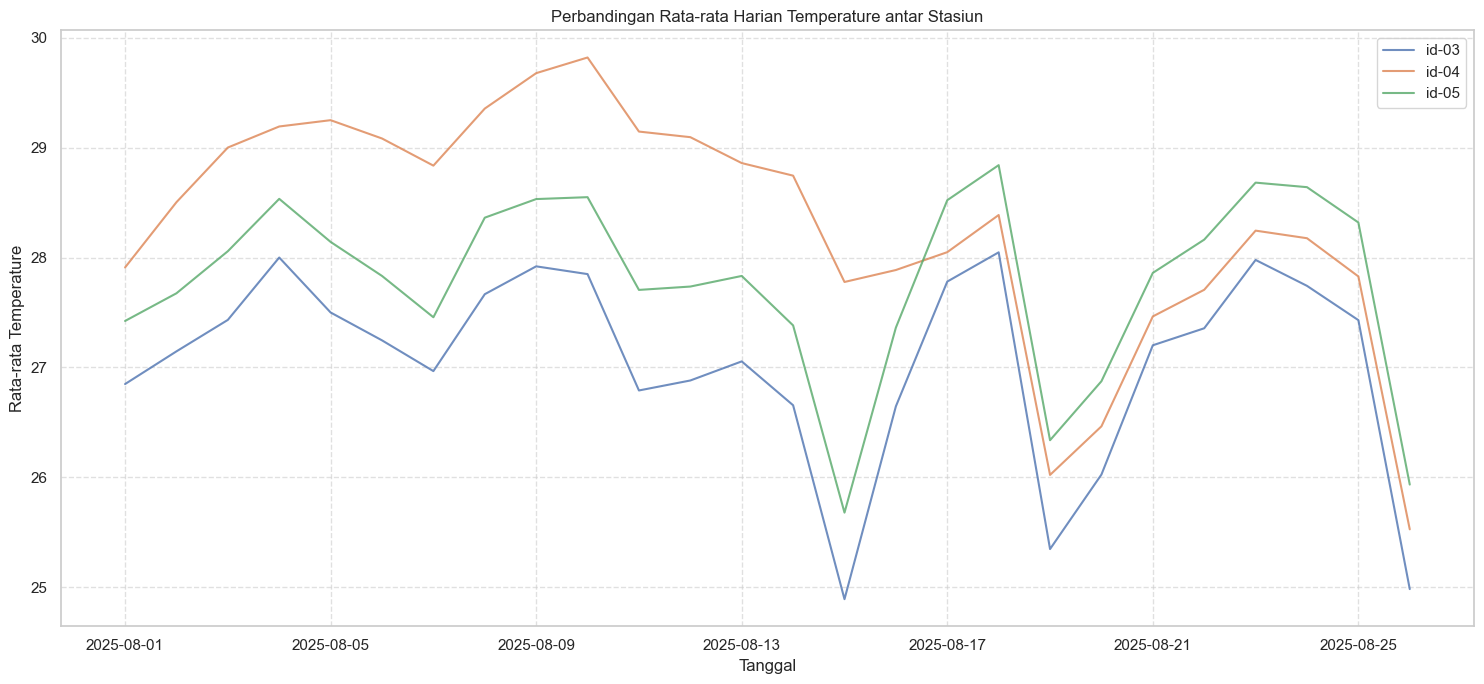


Menampilkan plot perbandingan kelembapan...


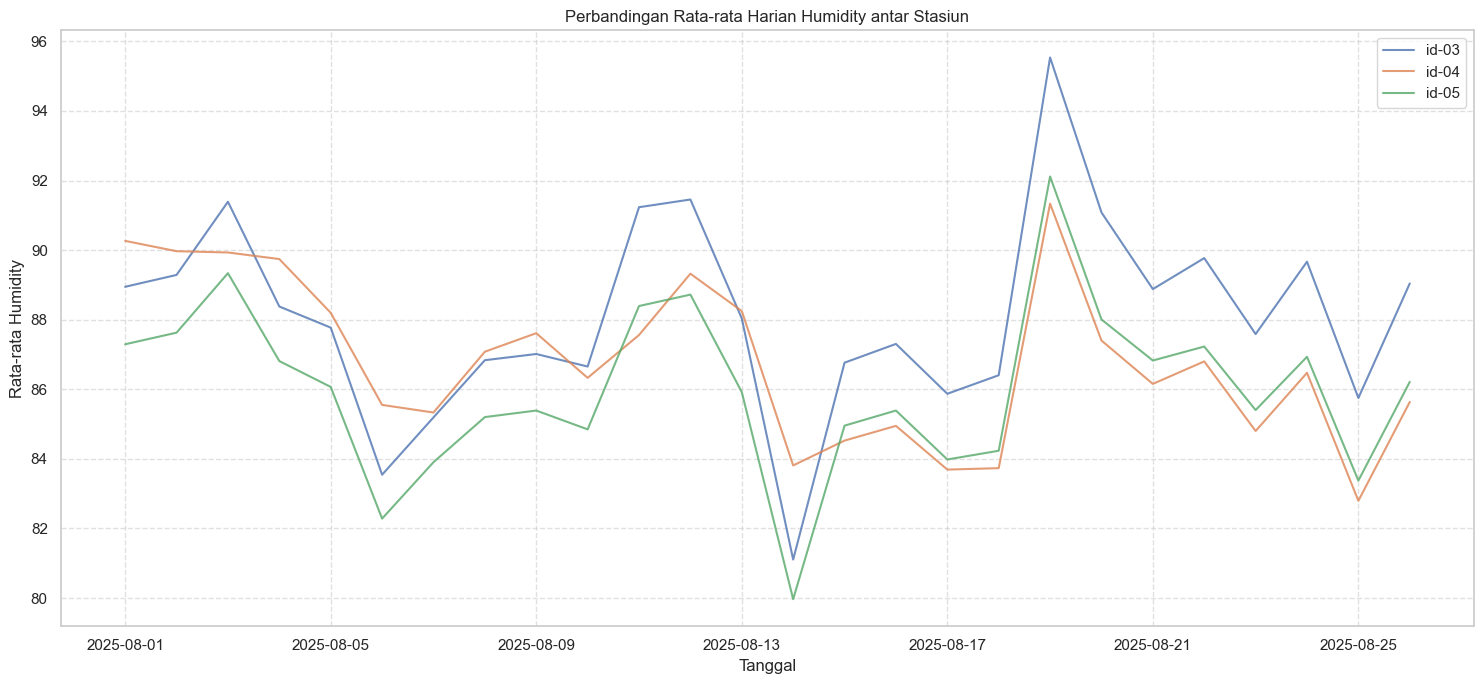


Menampilkan plot perbandingan tekanan udara...


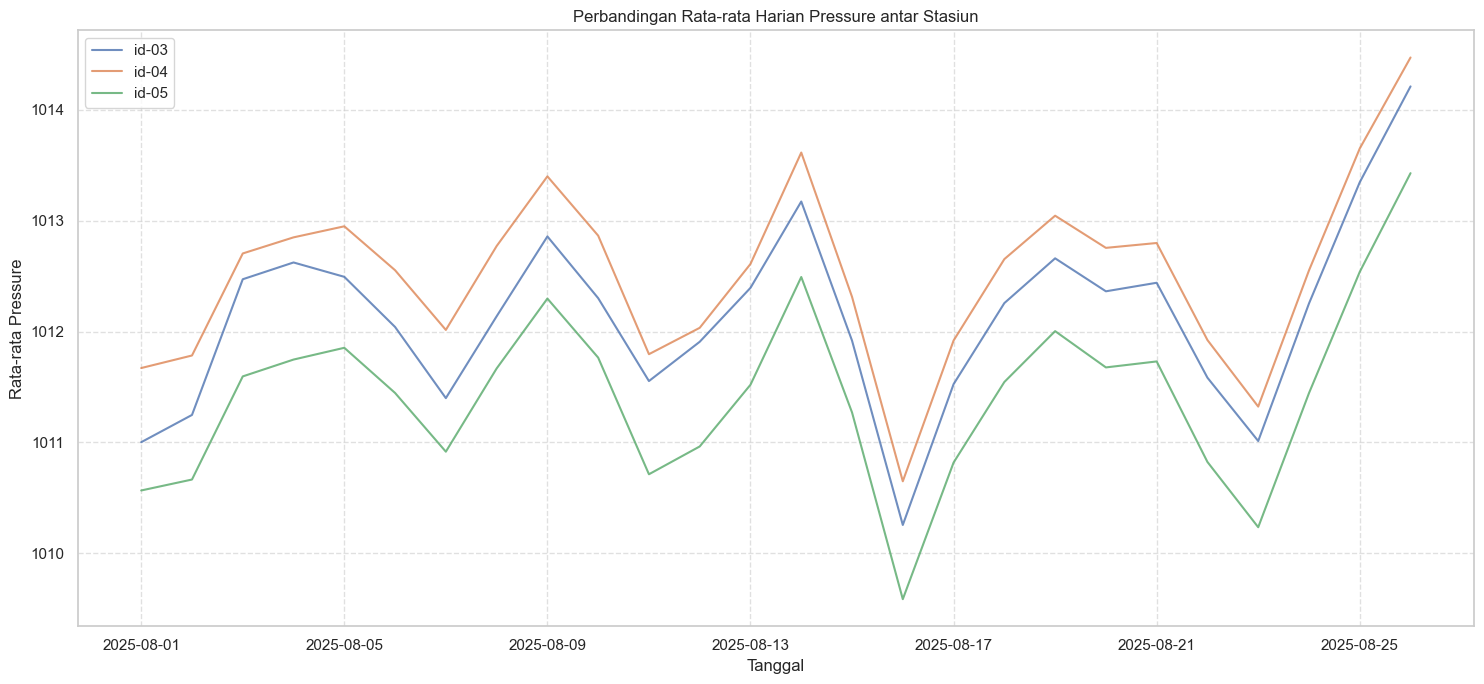

In [24]:
# Asumsi Anda sudah memiliki dictionary 'weather_dataframes' yang berisi
# DataFrame untuk setiap stasiun, dan fitur waktu sudah ditambahkan.

# Contoh penggunaan untuk mem-plot SUHU
print("Menampilkan plot perbandingan suhu...")
plot_station_comparison(weather_dataframes, 'temperature')

# Contoh penggunaan untuk mem-plot KELEMBAPAN
print("\nMenampilkan plot perbandingan kelembapan...")
plot_station_comparison(weather_dataframes, 'humidity')

# Contoh penggunaan untuk mem-plot TEKANAN UDARA
print("\nMenampilkan plot perbandingan tekanan udara...")
plot_station_comparison(weather_dataframes, 'pressure')

In [25]:
def plot_station_trends(data_dict, column_to_plot, freq='d'):
    """
    Membuat plot tren perbandingan untuk sebuah kolom dari beberapa stasiun cuaca.

    Args:
        data_dict (dict): Dictionary yang berisi {station_id: DataFrame}.
        column_to_plot (str): Nama kolom yang akan di-plot (misal: 'temperature').
        freq (str): Frekuensi untuk pengelompokan data.
                    'd' untuk harian (daily).
                    'h' untuk per jam (hourly).
    """
    # Menentukan label berdasarkan frekuensi
    freq_labels = {
        'd': {'label': 'Harian', 'xlabel': 'Tanggal'},
        'h': {'label': 'Per Jam', 'xlabel': 'Waktu (Jam)'}
    }
    
    # Pilih label yang sesuai, default ke 'Harian' jika freq tidak dikenali
    selected_freq = freq_labels.get(freq, freq_labels['d'])
    
    # Membuat figure dan axes untuk plot
    plt.figure(figsize=(15, 7))

    # Loop melalui setiap stasiun dalam dictionary
    for station_id, df in data_dict.items():
        if column_to_plot not in df.columns:
            print(f"Peringatan: Kolom '{column_to_plot}' tidak ada di stasiun {station_id}. Dilewati.")
            continue

        temp_df = df.copy()
        
        # Mengelompokkan data berdasarkan frekuensi (harian atau per jam)
        time_group_col = f'time_group_{freq}'
        temp_df[time_group_col] = temp_df['timestamp'].dt.floor(freq)
        trend_data = temp_df.groupby(time_group_col)[column_to_plot].mean().reset_index()

        # Plot data untuk stasiun saat ini
        plt.plot(trend_data[time_group_col], trend_data[column_to_plot], label=station_id, alpha=0.8)

    # Menambahkan detail pada plot
    plt.xlabel(selected_freq['xlabel'])
    plt.ylabel(f"Rata-rata {column_to_plot.capitalize()}")
    plt.title(f"Perbandingan Rata-rata {selected_freq['label']} {column_to_plot.capitalize()} antar Stasiun")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()

    # Menampilkan plot
    plt.show()

Menampilkan plot perbandingan suhu per jam...


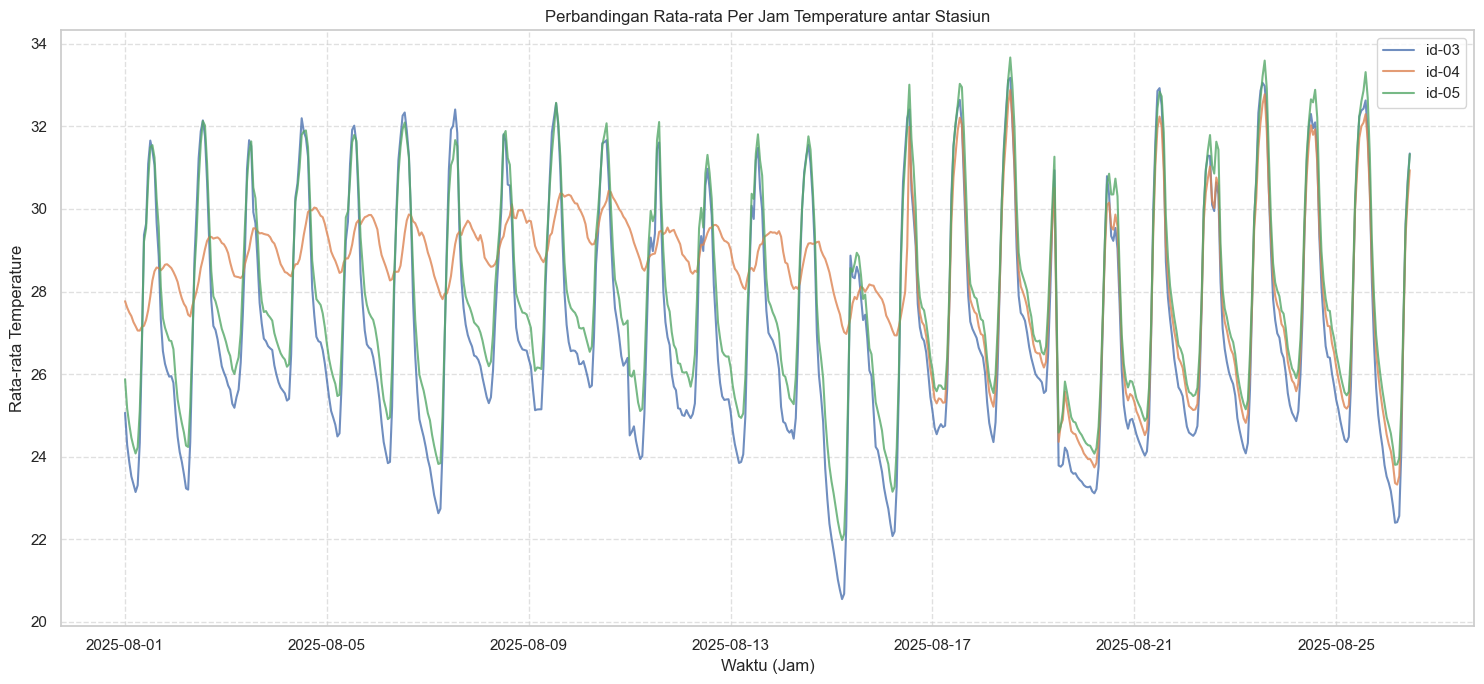

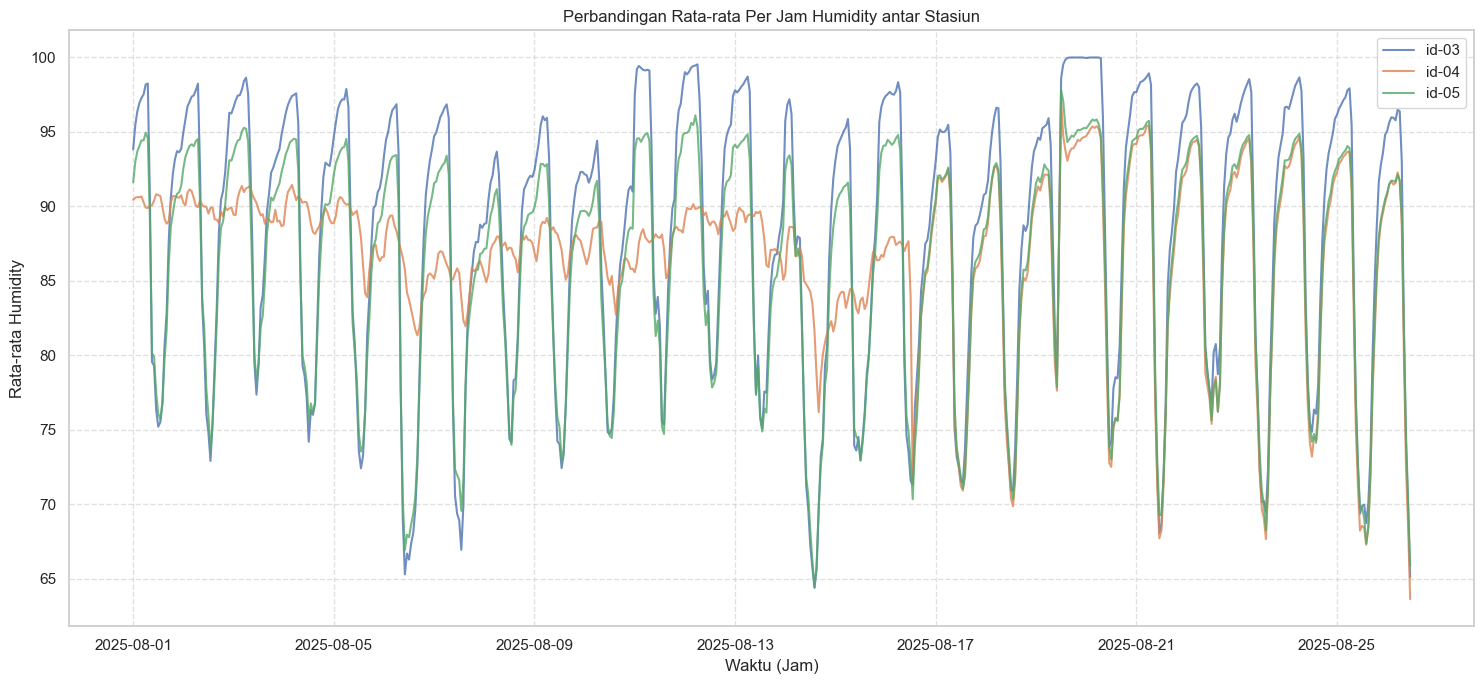

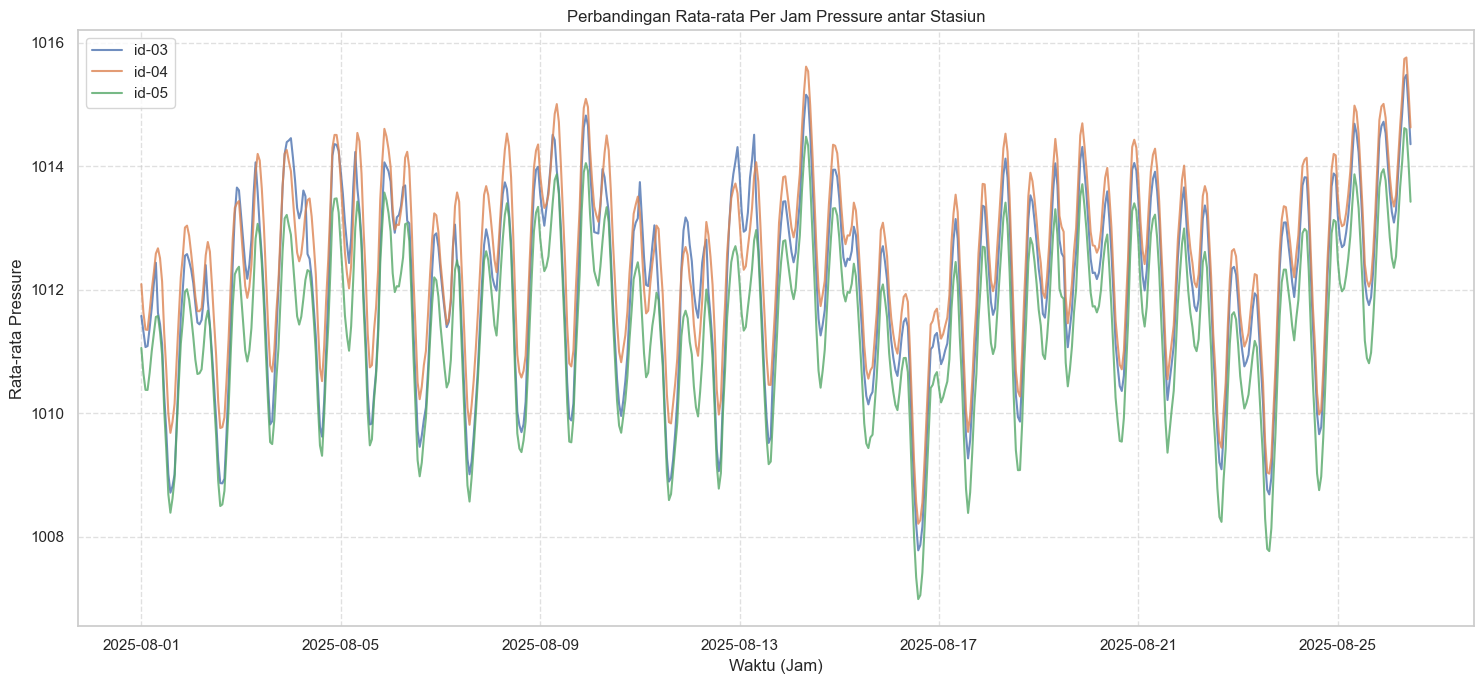


Menampilkan plot perbandingan kelembapan per hari...


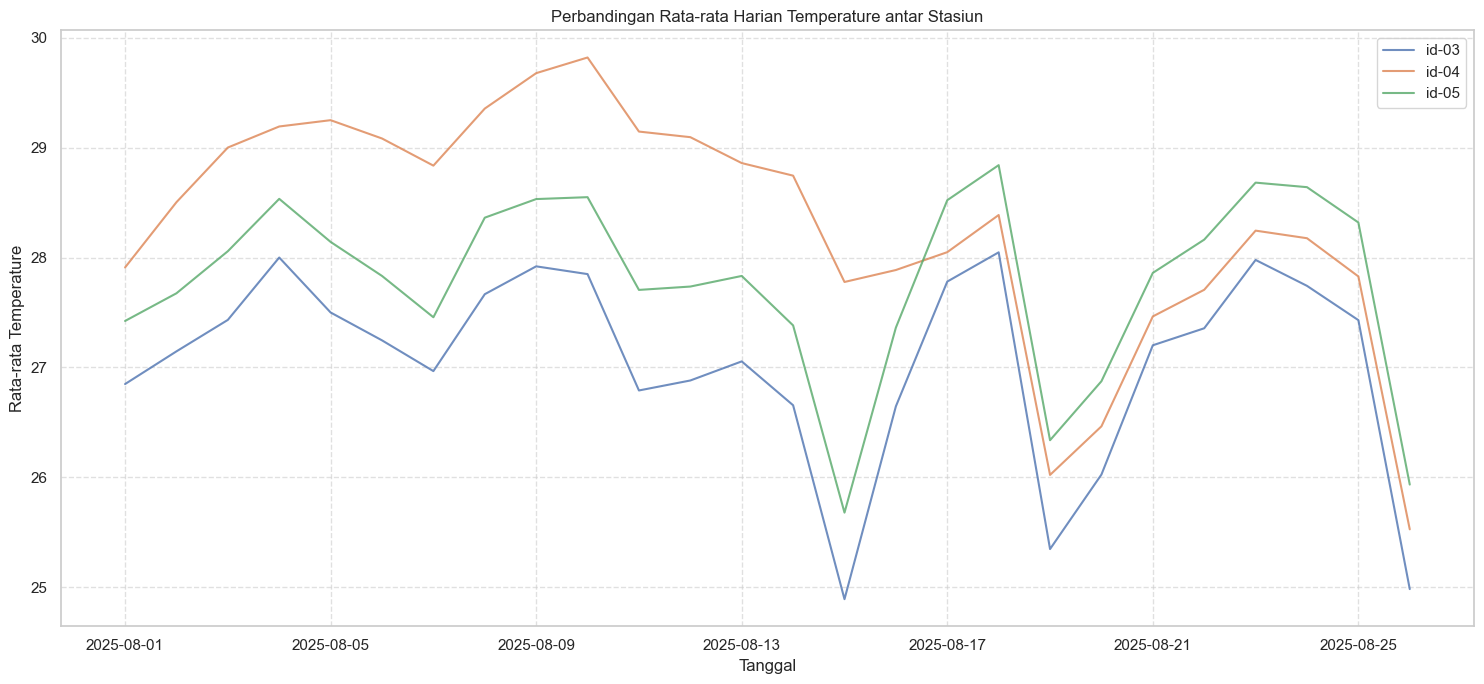

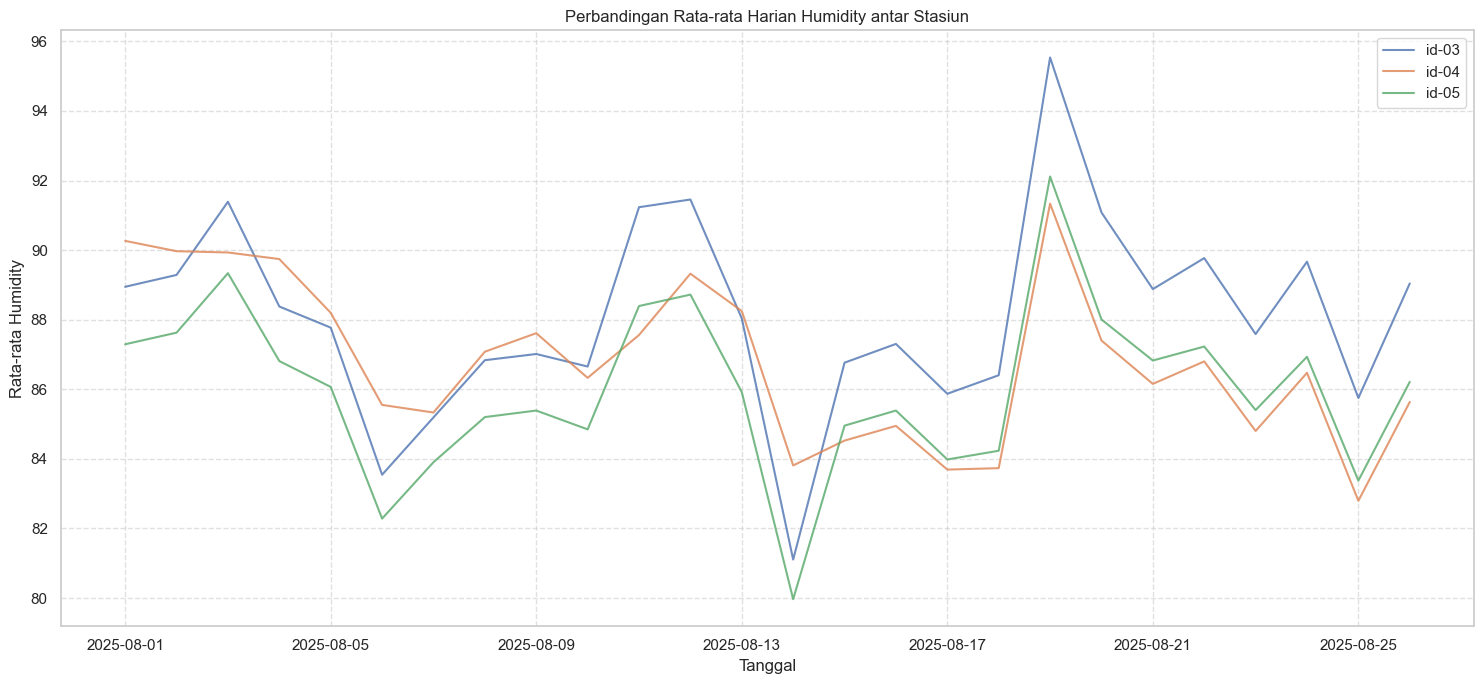

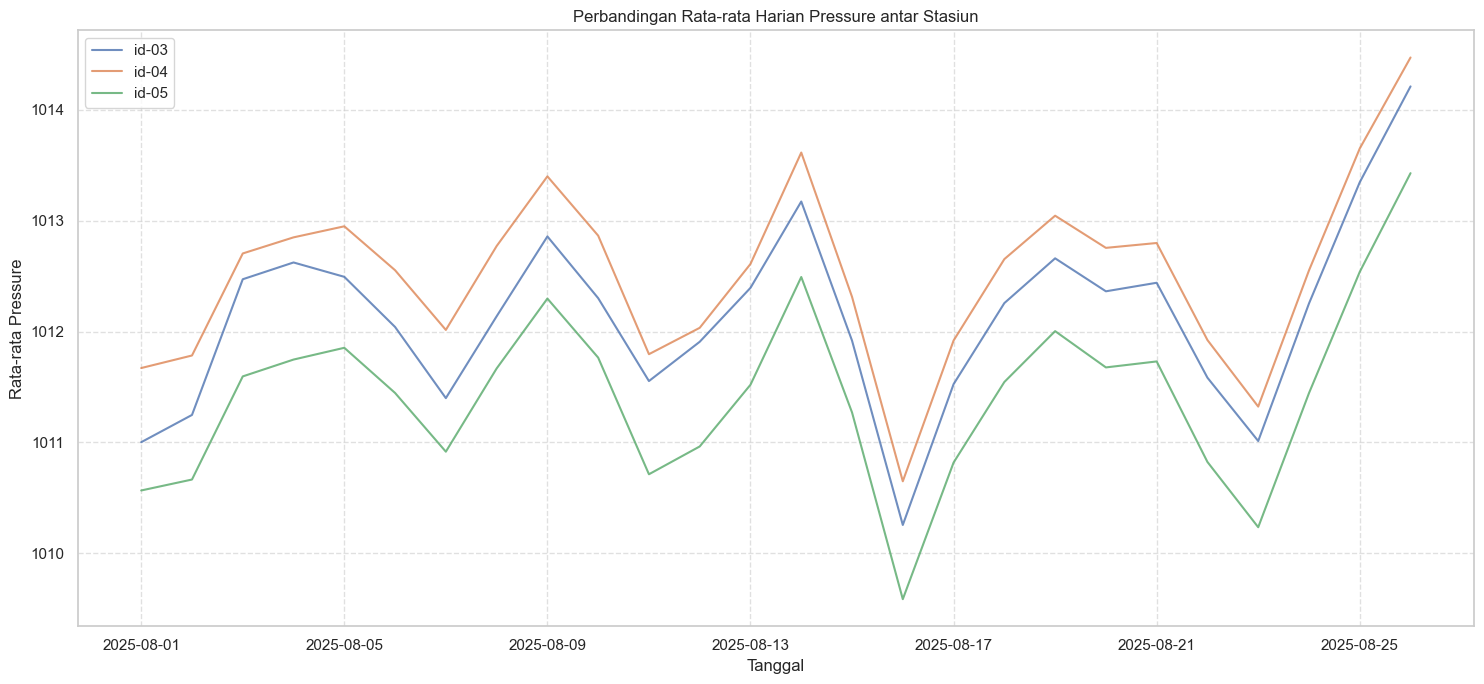

In [27]:
# Asumsi Anda sudah memiliki dictionary 'weather_dataframes'

# --- 1. Membuat Plot Rata-rata PER JAM ---
# Cukup atur freq='h'
print("Menampilkan plot perbandingan suhu per jam...")
plot_station_trends(weather_dataframes, 'temperature', freq='h')
plot_station_trends(weather_dataframes, 'humidity', freq='h')
plot_station_trends(weather_dataframes, 'pressure', freq='h')


# --- 2. Membuat Plot Rata-rata PER HARI ---
# Gunakan nilai default freq='d' atau tulis secara eksplisit
print("\nMenampilkan plot perbandingan kelembapan per hari...")
plot_station_trends(weather_dataframes, 'temperature', freq='d')
plot_station_trends(weather_dataframes, 'humidity', freq='d')
plot_station_trends(weather_dataframes, 'pressure', freq='d')